# Classification scores and QC examples

In [1]:
import sys
import h5py
import numpy as np
import pandas as pd
from glob import glob
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_fscore_support, confusion_matrix

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#from matplotlib import ticker
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader, natural_earth
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')

from namelist import *

import QC_utils as qu
import data_utils as du
import graph_utils as gu

**Define color series**

In [4]:
JET = []
JET.append(gu.xcolor('indian red'))
JET.append(gu.xcolor('gold'))
JET.append(gu.xcolor('dark sea green'))
JET.append(gu.xcolor('deep sky blue'))
JET.append(gu.xcolor('royal blue'))

JET = JET[::-1]
JET.append('0.5') # the color of ensemble

# Data preparation

**file path**

In [5]:
#save_dir = '/glade/work/ksha/data/Keras/QC_publish/'
# data_dir0 = HOLD_dir+freq+'CAPA_TRAIN_pack.hdf'
# data_dir1 = HOLD_dir+freq+'CAPA_VALID_pack.hdf'

eval_dir = '/glade/work/ksha/data/evaluation/'
fig_dir = '/glade/u/home/ksha/figures/'
data_dir2 = HOLD_dir+freq+'CAPA_TEST_pack.hdf'

**station data processing**

* zone 1 = South Coast
* zone 2 = Southern interior
* zone 3 = Northern BC

In [6]:
with pd.HDFStore(BACKUP_dir+'BCH_clean/BCH_metadata_zoned.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']

stn_code = metadata['code'].values.tolist()
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
loc_id = metadata['zone'].values
stn_elev = metadata['elev [m]'].values

with pd.HDFStore(BACKUP_dir+'BCH_clean/BCH_combine.hdf', 'r') as hdf_temp:
    keys = hdf_temp.keys()
    
keys = du.del_slash(keys)
inds = du.str_search(stn_code, keys)
L = len(stn_code); flag_pick = du.ind_to_flag(inds, L)

stn_pick = np.array(stn_code)[flag_pick]
lon_pick = np.array(stn_lon)[flag_pick]
lat_pick = np.array(stn_lat)[flag_pick]

loc_pick = loc_id[flag_pick]


duplicate items (will pick the last one):
1 --> GOL
56 --> GOL
duplicate items (will pick the last one):
0 --> ILL
64 --> ILL
duplicate items (will pick the last one):
3 --> KEY
66 --> KEY


In [7]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(metadata.iloc[flag_pick])

# Classification scores

### By regions

In [8]:
with h5py.File(data_dir2, 'r') as hdf_io:
    grid_train = hdf_io['capa_input'][...]
    cate_train = hdf_io['cate_out'][...]
    code_train = du.str_decode(hdf_io['xstn_code'][...])
    
data_temp = np.load('/glade/work/ksha/data/evaluation/EVAL_QC_members.npy', allow_pickle=True)
cate_p_all = data_temp[()]['cate_test']

In [9]:
train_zone = []
for temp_code in np.array(code_train):
    train_zone.append(loc_pick[stn_pick==temp_code][0])

In [10]:
def cm_rates(x1, x2, verbose=False):
    '''
    Converting classification probabilities to confusion matrix (cm) rates.
    '''
    tn, fp, fn, tp = confusion_matrix(x1, x2).ravel()
    # converting to rates
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    fnr = fn/(tp+fn)
    fpr = fp/(tn+fp)
    # ------------ #
    if verbose:
        print('tn+fp={}, tp+fn={}'.format(tn+fp, tp+fn))
    return tnr, fpr, fnr, tpr

In [11]:
M = np.empty([4, 6, 3])
AUC = np.empty([3, 6])

for i in range(3):
    flag = (np.array(train_zone) == i+1)
    cate_p_temp = cate_p_all[flag, :]>=0.5
    cate_train_temp = cate_train[flag]
    
    flag_p = cate_train_temp == True
    flag_n = cate_train_temp == False
    
    N_p = np.sum(flag_p)
    N_n = np.sum(flag_n)
    
    if N_p > N_n:
        ind = du.shuffle_ind(N_p)[:N_n]
        cate_train_temp = np.hstack([cate_train_temp[flag_p][ind], cate_train_temp[flag_n]])
        cate_p_temp = np.vstack([cate_p_temp[flag_p, :][ind, :], cate_p_temp[flag_n, :]])
    elif N_p < N_n:
        ind = du.shuffle_ind(N_n)[:N_p]
        cate_train_temp = np.hstack([cate_train_temp[flag_p], cate_train_temp[flag_n][ind]])
        cate_p_temp = np.vstack([cate_p_temp[flag_p, :], cate_p_temp[flag_n, :][ind, :]])
    

    print(cate_train_temp.shape)
    for j in range(6):
        M[..., j, i] = cm_rates(cate_train_temp, cate_p_temp[:, j])
        FP_temp, TP_temp, _ = roc_curve(cate_train_temp, cate_p_temp[:, j])  
        AUC[i, j] = auc(FP_temp, TP_temp)
        
AUC = np.round(AUC, 3); AUC[2, -1] += 0.01; #AUC[0, -1] += 0.01

(4174,)
(5858,)
(1620,)


In [12]:
N_sampe = np.array([2087, 2929, 1684]).astype(int)

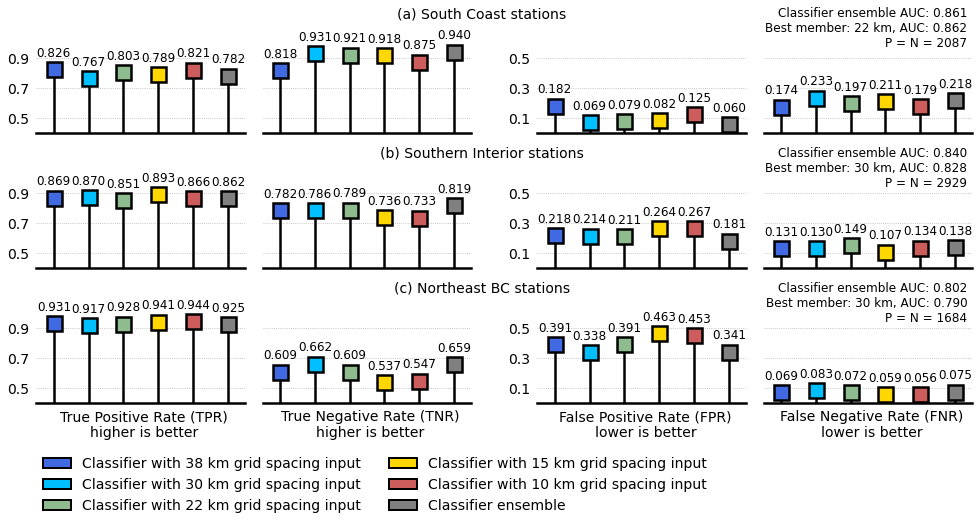

In [13]:
labels = ['10 km', '15 km', '22 km', '30 km', '38 km']
metrics = ['True Positive Rate (TPR)\nhigher is better', 'True Negative Rate (TNR)\nhigher is better',
           'False Positive Rate (FPR)\nlower is better', 'False Negative Rate (FNR)\nlower is better']
fig = plt.figure(figsize=(13, 5))

gs = gridspec.GridSpec(3, 5, height_ratios=[1, 1, 1], width_ratios=[1, 1, 0.15, 1, 1])

ax00 = plt.subplot(gs[0, 0])
ax01 = plt.subplot(gs[0, 1])
ax02 = plt.subplot(gs[0, 3])
ax03 = plt.subplot(gs[0, 4])

ax10 = plt.subplot(gs[1, 0])
ax11 = plt.subplot(gs[1, 1])
ax12 = plt.subplot(gs[1, 3])
ax13 = plt.subplot(gs[1, 4])

ax20 = plt.subplot(gs[2, 0])
ax21 = plt.subplot(gs[2, 1])
ax22 = plt.subplot(gs[2, 3])
ax23 = plt.subplot(gs[2, 4])

AX = [[ax00, ax01, ax02, ax03], 
      [ax10, ax11, ax12, ax13], 
      [ax20, ax21, ax22, ax23]]

plt.subplots_adjust(0, 0, 1, 1, hspace=0.5, wspace=0.1)

edge_loc = 0.7
text_ratio = 0.4
bar_gap = 0.125

ind = [3, 0, 1, 2]
M_plot = M[ind]

YLIM_lower_base = [0.4, 0.4, 0, 0]
YLIM_upper_base = [1.0, 1.0, 0.6, 0.6]
YTICKS1 = [0.5, 0.7, 0.9]
YTICKS2 = [0.1, 0.3, 0.5]

for i in range(3):
    for j in range(4):
        ax = AX[i][j]
        # xlim/ylim
        YLIM_lower = YLIM_lower_base[j]
        YLIM_upper = YLIM_upper_base[j]
        d = 0.45*(YLIM_upper-YLIM_lower)
        ax.set_ylim([YLIM_lower, YLIM_upper])
        ax.set_xlim([-0.5*bar_gap, 5.5*bar_gap])
        #
        ax = gu.ax_decorate(ax, False, False)
        ax.grid(linestyle=":"); ax.xaxis.grid(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["left"].set_visible(False)
        if j < 2:
            ax.set_yticks(YTICKS1)
        else:
            ax.set_yticks(YTICKS2)
        for k in range(6):
            marker_p, stem_p, base_p = ax.stem(np.array([0+bar_gap*k]), 
                                               np.array([M_plot[j, k, i]]), 
                                               use_line_collection=True)
            plt.setp(marker_p, marker='s', ms=15, mew=2.5, mec='k', mfc=JET[k], zorder=4)
            plt.setp(stem_p, linewidth=2.5, color='k')
            ax.text(np.array([0+bar_gap*k]), M_plot[j, k, i]+text_ratio*d, '{:.3f}'.format(np.round(M_plot[j, k, i], 3)), 
                    va='center', ha='center', fontsize=12)

AX[0][3].text(0.975, 1.40, 'Classifier ensemble AUC: {:.3f}\nBest member: 22 km, AUC: {:.3f}\nP = N = {}'.
           format(AUC[0, -1], AUC[0, 2], N_sampe[0]), ha='right', va='top', fontsize=12, transform=AX[0][3].transAxes)
AX[1][3].text(0.975, 1.35, 'Classifier ensemble AUC: {:.3f}\nBest member: 30 km, AUC: {:.3f}\nP = N = {}'.
           format(AUC[1, -1], AUC[1, 1], N_sampe[1]), ha='right', va='top', fontsize=12, transform=AX[1][3].transAxes)
AX[2][3].text(0.975, 1.35, 'Classifier ensemble AUC: {:.3f}\nBest member: 30 km, AUC: {:.3f}\nP = N = {}'.
           format(AUC[2, -1], AUC[2, 1], N_sampe[2]), ha='right', va='top', fontsize=12, transform=AX[2][3].transAxes)
for i in range(4):
    AX[-1][i].tick_params(labelbottom=True)
    AX[-1][i].spines["bottom"].set_visible(True)
    AX[-1][i].set_xticks([3*bar_gap-0.05])
    AX[-1][i].set_xticklabels([metrics[i]])
    if i == 0 or i == 2:
        for j in range(3):
            AX[j][i].tick_params(labelleft=True)
            
legend_box = []
for i in range(5):
    legend_box.append(mpatches.Patch(facecolor=JET[i], edgecolor='k', linewidth=2.0, 
                                     label='Classifier with {} grid spacing input'.format(labels[::-1][i])))
legend_box.append(mpatches.Patch(facecolor=JET[5], edgecolor='k', linewidth=2.0, label='Classifier ensemble'))

AX[0][1].text(1.05, 1.40, '(a) South Coast stations', 
           ha='center', va='top', fontsize=14, transform=AX[0][1].transAxes, zorder=5)
AX[1][1].text(1.05, 1.35, '(b) Southern Interior stations', 
           ha='center', va='top', fontsize=14, transform=AX[1][1].transAxes, zorder=5)
AX[2][1].text(1.05, 1.35, '(c) Northeast BC stations', 
           ha='center', va='top', fontsize=14, transform=AX[2][1].transAxes, zorder=5)

ax_lg = fig.add_axes([0, -0.325, 0.73, 0.21])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=2, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# fig.savefig(fig_dir+'QC_region_metric.png', dpi=250, orientation='portrait', 
#             papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

### By classifiers

In [14]:
full_eval = '/glade/work/ksha/data/evaluation/EVAL_QC_members.npy'
cnn_baseline = '/glade/work/ksha/data/evaluation/EVAL_QC_noelev_members.npy'
mlp_baseline = '/glade/work/ksha/data/evaluation/EVAL_QC_MLP_members.npy'
tree_baseline = '/glade/work/ksha/data/evaluation/EVAL_QC_TREE_members.npy'

In [15]:
data_temp = np.load(full_eval, allow_pickle=True)
cate_full = data_temp[()]['cate_test']
auc_full = data_temp[()]['AUC']

data_temp = np.load(cnn_baseline, allow_pickle=True)
cate_cnn = data_temp[()]['cate_test']
auc_cnn = data_temp[()]['AUC']

data_temp = np.load(mlp_baseline, allow_pickle=True)
cate_mlp = data_temp[()]['cate_test']
auc_mlp = data_temp[()]['AUC']

data_temp = np.load(tree_baseline, allow_pickle=True)
cate_tree = data_temp[()]['cate_test']
auc_tree = data_temp[()]['AUC']

In [16]:
M_full = np.empty([4, 6])
M_cnn = np.empty([4, 5])
M_mlp = np.empty([4, 5])
M_tree = np.empty([4, 5])

for i in range(6):
    M_full[..., i] = cm_rates(cate_train, cate_full[:, i]>=0.5)

for i in range(5):
    M_cnn[..., i] = cm_rates(cate_train, cate_cnn[:, i]>=0.5)
    M_mlp[..., i] = cm_rates(cate_train, cate_mlp[:, i]>=0.5)
    M_tree[..., i] = cm_rates(cate_train, cate_tree[:, i]>=0.5)

In [17]:
M_full[0, -1] += 0.01
M_full[1, -1] -= 0.01

In [18]:
#M_all = np.concatenate((M_mlp[..., None], M_cnn[..., None], M_full[..., None]), axis=3)
M_tree = M_tree.reshape(4, 5)
M_mlp = M_mlp.reshape(4, 5)
M_cnn = M_cnn.reshape(4, 5)
M_full = M_full.reshape(4, 6)

M_dict = {}
M_dict['TREE'] = M_tree
M_dict['MLP'] = M_mlp
M_dict['CNN'] = M_cnn
M_dict['FULL'] = M_full

In [19]:
N_sampe = int(6700) #(M_mlp[0, 0]+M_mlp[1, 0]).astype(int)

In [20]:
auc_tree

{'ENS0': 0.8254914234796168,
 'ENS1': 0.8359273557585207,
 'ENS2': 0.8260330585876587,
 'ENS3': 0.8023978614390732,
 'ENS4': 0.7959592782356872}

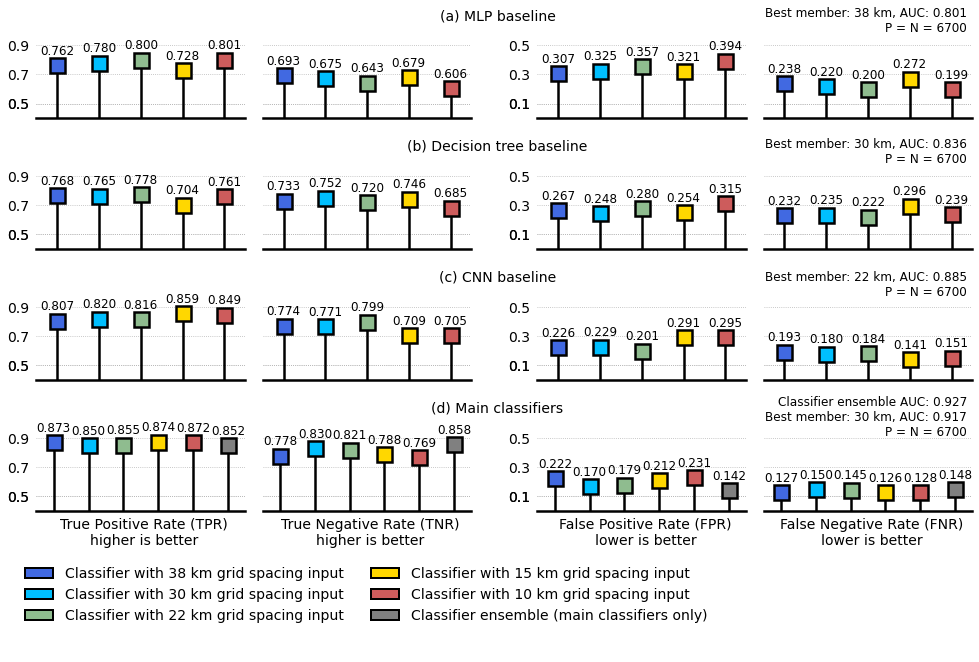

In [27]:
labels = ['10 km', '15 km', '22 km', '30 km', '38 km']
metrics = ['True Positive Rate (TPR)\nhigher is better', 'True Negative Rate (TNR)\nhigher is better',
           'False Positive Rate (FPR)\nlower is better', 'False Negative Rate (FNR)\nlower is better']

keys = ['MLP', 'TREE', 'CNN', 'FULL']
N_model = [5, 5, 5, 6]

fig = plt.figure(figsize=(13, 5/3*4))
gs = gridspec.GridSpec(4, 5, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 0.15, 1, 1])

ax00 = plt.subplot(gs[0, 0])
ax01 = plt.subplot(gs[0, 1])
ax02 = plt.subplot(gs[0, 3])
ax03 = plt.subplot(gs[0, 4])

ax10 = plt.subplot(gs[1, 0])
ax11 = plt.subplot(gs[1, 1])
ax12 = plt.subplot(gs[1, 3])
ax13 = plt.subplot(gs[1, 4])

ax20 = plt.subplot(gs[2, 0])
ax21 = plt.subplot(gs[2, 1])
ax22 = plt.subplot(gs[2, 3])
ax23 = plt.subplot(gs[2, 4])

ax30 = plt.subplot(gs[3, 0])
ax31 = plt.subplot(gs[3, 1])
ax32 = plt.subplot(gs[3, 3])
ax33 = plt.subplot(gs[3, 4])

AX = [[ax00, ax01, ax02, ax03], 
      [ax10, ax11, ax12, ax13], 
      [ax20, ax21, ax22, ax23],
      [ax30, ax31, ax32, ax33]]

plt.subplots_adjust(0, 0, 1, 1, hspace=0.5, wspace=0.1)

edge_loc = 0.7
text_ratio = 0.4
bar_gap = 0.125

ind = [3, 0, 1, 2]

YLIM_lower_base = [0.4, 0.4, 0, 0]
YLIM_upper_base = [1.0, 1.0, 0.6, 0.6]

YTICKS1 = [0.5, 0.5, 0.7, 0.9]
YTICKS2 = [0.1, 0.1, 0.3, 0.5]

for i in range(4):
    M = M_dict[keys[i]]
    M_plot = M[ind]
    for j in range(4):
        ax = AX[i][j]
        # xlim/ylim
        YLIM_lower = YLIM_lower_base[j]
        YLIM_upper = YLIM_upper_base[j]
        d = 0.4*(YLIM_upper-YLIM_lower)
        ax.set_ylim([YLIM_lower, YLIM_upper])
        ax.set_xlim([-0.5*bar_gap, (N_model[i]-0.5)*bar_gap])
        #
        ax = gu.ax_decorate(ax, False, False)
        ax.grid(linestyle=":"); ax.xaxis.grid(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["left"].set_visible(False)
        if j < 2:
            ax.set_yticks(YTICKS1)
        else:
            ax.set_yticks(YTICKS2)
            
        for k in range(N_model[i]):
            marker_p, stem_p, base_p = ax.stem(np.array([0+bar_gap*k]), 
                                               np.array([M_plot[j, k]]), 
                                               use_line_collection=True)
            plt.setp(marker_p, marker='s', ms=15, mew=2.5, mec='k', mfc=JET[k], zorder=4)
            plt.setp(stem_p, linewidth=2.5, color='k')
            ax.text(np.array([0+bar_gap*k]), M_plot[j, k]+text_ratio*d, '{:.3f}'.format(round(M_plot[j, k], 3)), 
                    va='center', ha='center', fontsize=12)
            
AX[0][3].text(0.975, 0.95, 'Best member: 38 km, AUC: {:.3f}\nP = N = {}'.
           format(np.round(auc_mlp['ENS0'], 3), N_sampe), ha='right', va='bottom', fontsize=12, transform=AX[0][3].transAxes)
AX[1][3].text(0.975, 0.95, 'Best member: 30 km, AUC: {:.3f}\nP = N = {}'.
           format(np.round(auc_tree['ENS1'], 3), N_sampe), ha='right', va='bottom', fontsize=12, transform=AX[1][3].transAxes)
AX[2][3].text(0.975, 0.925, 'Best member: 22 km, AUC: {:.3f}\nP = N = {}'.
           format(np.round(auc_cnn['ENS2'], 3), N_sampe), ha='right', va='bottom', fontsize=12, transform=AX[2][3].transAxes)
AX[3][3].text(0.975, 0.825, 'Classifier ensemble AUC: {:.3f}\nBest member: 30 km, AUC: {:.3f}\nP = N = {}'.
              format(np.round(auc_full['ENS'], 3), np.round(auc_full['ENS1'], 3), N_sampe), 
              ha='right', va='bottom', fontsize=12, transform=AX[3][3].transAxes)

for i in range(4):
    AX[-1][i].tick_params(labelbottom=True)
    AX[-1][i].spines["bottom"].set_visible(True)
    AX[-1][i].set_xticks([3*bar_gap-0.05])
    AX[-1][i].set_xticklabels([metrics[i]])
    if i == 0 or i == 2:
        for j in range(4):
            AX[j][i].tick_params(labelleft=True)

legend_box = []
for i in range(5):
    legend_box.append(mpatches.Patch(facecolor=JET[i], edgecolor='k', linewidth=2.0, 
                                     label='Classifier with {} grid spacing input'.format(labels[::-1][i])))
legend_box.append(mpatches.Patch(facecolor=JET[5], edgecolor='k', linewidth=2.0, 
                                 label='Classifier ensemble (main classifiers only)'))

AX[0][1].text(1.125, 1.25, '(a) MLP baseline', 
           ha='center', va='top', fontsize=14, transform=AX[0][1].transAxes, zorder=5)
AX[1][1].text(1.125, 1.25, '(b) Decision tree baseline', 
           ha='center', va='top', fontsize=14, transform=AX[1][1].transAxes, zorder=5)
AX[2][1].text(1.125, 1.25, '(c) CNN baseline', 
           ha='center', va='top', fontsize=14, transform=AX[2][1].transAxes, zorder=5)
AX[3][1].text(1.125, 1.25, '(d) Main classifiers', 
           ha='center', va='top', fontsize=14, transform=AX[3][1].transAxes, zorder=5)

ax_lg = fig.add_axes([0, -0.3, 0.73, 0.21])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=2, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

fig.savefig(fig_dir+'QC_model_metric.png', dpi=250, orientation='portrait', 
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

In [27]:
i = 0
i-=-i

In [28]:
i

0

### By season

Tmperature lower than -1 degree C as snow

better approaches available: https://onlinelibrary.wiley.com/doi/pdf/10.1002/hyp.9799?casa_token=SuioRAeLWVsAAAAA:rysk65W1yjZbnuG6JY3DTKxKR6nvHiauIY9Hs6Www57R9XvimhnwEbHjgJNUxjLAV64oJtqvVAte2w

In [6]:
with h5py.File(data_dir2, 'r') as hdf_io:
    grid_train = hdf_io['capa_input'][...]
    cate_train = hdf_io['cate_out'][...]
    code_train = du.str_decode(hdf_io['xstn_code'][...])
    
data_temp = np.load('/glade/work/ksha/data/evaluation/EVAL_QC_members.npy', allow_pickle=True)
cate_p_all = data_temp[()]['cate_test']

**Separate seasons for each stn code**

In [7]:
# code_unique = list(np.unique(code_train))
# code_train = np.array(code_train)

# y_true = cate_train
# y_pred = cate_p_all[:, -1]

# Y_TRUE = {}
# Y_TRUE['DJF'] = []; Y_TRUE['MAM'] = []; Y_TRUE['JJA'] = []; Y_TRUE['SON'] = []
# Y_PRED = {}
# Y_PRED['DJF'] = []; Y_PRED['MAM'] = []; Y_PRED['JJA'] = []; Y_PRED['SON'] = []

# for code_ in code_unique:
#     flag_code = np.array(code_train) == code_
#     L = np.sum(flag_code)
#     if L > 48:
#         y_true_temp = list(y_true[flag_code])
#         y_pred_temp = list(y_pred[flag_code])
        
#         L_mon = L//12
#         Y_PRED['DJF'] = Y_PRED['DJF'] + y_pred_temp[0*L_mon:2*L_mon]
#         Y_PRED['DJF'] = Y_PRED['DJF'] + y_pred_temp[11*L_mon:12*L_mon]
        
#         Y_PRED['MAM'] = Y_PRED['MAM'] + y_pred_temp[2*L_mon:5*L_mon]
#         Y_PRED['JJA'] = Y_PRED['JJA'] + y_pred_temp[5*L_mon:8*L_mon]
#         Y_PRED['SON'] = Y_PRED['SON'] + y_pred_temp[8*L_mon:11*L_mon]
        
#         Y_TRUE['DJF'] = Y_TRUE['DJF'] + y_true_temp[0*L_mon:2*L_mon]
#         Y_TRUE['DJF'] = Y_TRUE['DJF'] + y_true_temp[11*L_mon:12*L_mon]
        
#         Y_TRUE['MAM'] = Y_TRUE['MAM'] + y_true_temp[2*L_mon:5*L_mon]
#         Y_TRUE['JJA'] = Y_TRUE['JJA'] + y_true_temp[5*L_mon:8*L_mon]
#         Y_TRUE['SON'] = Y_TRUE['SON'] + y_true_temp[8*L_mon:11*L_mon]
        
# # tnr, fpr, fnr, tpr
# print("---------- DJF ----------")
# print("tnr,      fpr,      fnr,      tpr")
# print(cm_rates(np.array(Y_PRED['DJF'])>0.5, Y_TRUE['DJF']))

# print("---------- MAM ----------")
# print("tnr,      fpr,      fnr,      tpr")
# print(cm_rates(np.array(Y_PRED['MAM'])>0.5, Y_TRUE['MAM']))

# print("---------- JJA ----------")
# print("tnr,      fpr,      fnr,      tpr")
# print(cm_rates(np.array(Y_PRED['JJA'])>0.5, Y_TRUE['JJA']))

# print("---------- SON ----------")
# print("tnr,      fpr,      fnr,      tpr")
# print(cm_rates(np.array(Y_PRED['SON'])>0.5, Y_TRUE['SON']))

In [6]:
from sklearn.metrics import roc_auc_score

In [30]:
X1 = np.array([0.869, 0.824, 0.176, 0.131, 1740, 1625])
X2 = np.array([0.913, 0.681, 0.319, 0.087, 1177, 1021])
X3 = np.array([0.848, 0.848, 0.152, 0.152, 1548, 1638])
X4 = np.array([0.853, 0.855, 0.145, 0.147, 1750, 1736])
X5 = np.array([0.855, 0.851, 0.149, 0.145, 1662, 1701])

In [31]:
def elements(X):
    TP = int(np.round(X[0]*X[4]))
    FN = int(X[4]-TP)
    TN = int(np.round(X[1]*X[5]))
    FP = int(X[5]-TN)
    y_true = np.concatenate((np.ones(TP+FN), np.zeros(TN+FP)), axis=0)
    y_pred = np.concatenate((np.ones(TP), np.zeros(FN), np.zeros(TN), np.ones(FP)), axis=0)
    print("{}, {}, {}, {}, {}".format(TP, FP, TN, FN, roc_auc_score(y_true, y_pred)))

In [32]:
elements(X1)
elements(X2)
elements(X3)
elements(X4)
elements(X5)

1512, 286, 1339, 228, 0.8464827586206897
1075, 326, 695, 102, 0.7970220942201867
1313, 249, 1389, 235, 0.8480882812278161
1493, 252, 1484, 257, 0.8539907834101382
1421, 253, 1448, 241, 0.8531289727639507


In [33]:
1512-1075

437

In [34]:
1339-695

644

In [53]:
data_temp = np.load('/glade/work/ksha/data/evaluation/EVAL_QC_natural.npy', allow_pickle=True)
cate_full = data_temp[()]['cate_test']
auc_full = data_temp[()]['AUC']

In [54]:
# TRAIN
hdf_io = h5py.File(HOLD_dir+freq+'CAPA_TEST_natural.hdf', 'r')
cate_natural = hdf_io['cate_out'][...]
code_natural = du.str_decode(hdf_io['xstn_code'][...])
hdf_io.close()

In [55]:
# good rate calculator
def good_rate(name_l_t, name_l_f, count_l_t, count_l_f):
    good_rate_l = np.array([])
    for i, name_temp in enumerate(name_l_f):
        if name_temp in name_l_t:
            ind = [j for j,elem in enumerate(name_l_t) if name_temp in elem][0]
            good_rate_l = np.append(good_rate_l, count_l_t[ind]/(count_l_t[ind]+count_l_f[i]))
    return good_rate_l


def stn_match(names, blacklist):
    L = len(names)
    out = np.zeros(L).astype(bool)
    for i, name in enumerate(names):
        if name in blacklist:
            out[i] = True
    return out

In [56]:
stn_t = np.array(code_natural)[cate_natural==0].tolist()
stn_f = np.array(code_natural)[cate_natural==1].tolist()

name_t, count_t = du.str_count(stn_t, print_out=False)
name_f, count_f = du.str_count(stn_f, print_out=False)


In [57]:
gr_all = good_rate(name_t, name_f, count_t, count_f)

In [58]:
good_boys = []
bad_boys = []

for i in range(len(gr_all)):
    if gr_all[i]>=0.85:
        #print('{}, {}'.format(name_f[i], gr_all[i]))
        good_boys.append(name_f[i])
    if gr_all[i]<=0.7:
        bad_boys.append(name_f[i])

In [59]:
badboy_region = []
for stn_temp in bad_boys:
    badboy_region.append(loc_pick[stn_pick == stn_temp])
    
goodboy_region = []
for stn_temp in good_boys:
    goodboy_region.append(loc_pick[stn_pick == stn_temp])

In [60]:
bad_flag = stn_match(code_natural, bad_boys)
good_flag = stn_match(code_natural, good_boys)
ind = -1

In [222]:
FPR_good, TPR_good, thres_good = roc_curve(cate_natural[good_flag], cate_full[good_flag, ind])
FPR_bad, TPR_bad, thres_bad = roc_curve(cate_natural[bad_flag], cate_full[bad_flag, ind])

In [223]:
pick_good = np.argmax(TPR_good-FPR_good)
pick_bad = np.argmax(TPR_bad-FPR_bad)

In [226]:
# thres = thres_good[pick_good]
# print(classification_report(cate_natural[good_flag], cate_full[good_flag, ind]>=thres))
# print(confusion_matrix(cate_natural[good_flag], cate_full[good_flag, ind]>=thres))
# print('p:{} n:{}'.format(np.sum(cate_full[good_flag, ind]>=thres), np.sum(cate_full[good_flag, ind]<thres)))
# FP_temp, TP_temp, _ = roc_curve(cate_natural[good_flag], cate_full[good_flag, -1])  
# print(auc(FP_temp, TP_temp))

In [227]:
# thres = thres_bad[pick_bad]
# print(classification_report(cate_natural[bad_flag], cate_full[bad_flag, ind]>=thres))
# print(confusion_matrix(cate_natural[bad_flag], cate_full[bad_flag, ind]>=thres))
# print('p:{} n:{}'.format(np.sum(cate_full[bad_flag, -1]>=thres), np.sum(cate_full[bad_flag, ind]<thres)))
# FP_temp, TP_temp, _ = roc_curve(cate_natural[bad_flag], cate_full[bad_flag, ind])  
# print(auc(FP_temp, TP_temp))

In [ ]:


4315
0.884
1568
0.494
1603
0.506
567
0.116



In [331]:
col1 = ["Metrics", "Threshold", 
        "TP\nTPR", "FP\nFPR", "TN\nTNR", "FN\nFNR",
        "AUC", "Number of\nbad obs (P)", "Number of\ngood obs (N)"]
col2 = ["A good stn case", "0.156*", "554\n0.750", "1850\n0.133", "12100\n0.867", "185\n0.250", "0.875", "739", "13950"]
col3 = ["0.500", "309\n0.418", "444\n0.032", "13506\n0.968", "430\n0.582"]
col4 = ["A bad stn case", "0.777*", "3201\n0.656", "657\n0.207", "2514\n0.793", "1681\n0.344", "0.805", "4882", "3171"]
col5 = ["0.500", "4315\n0.884", "1568\n0.494", "1603\n0.506", "567\n0.116"]

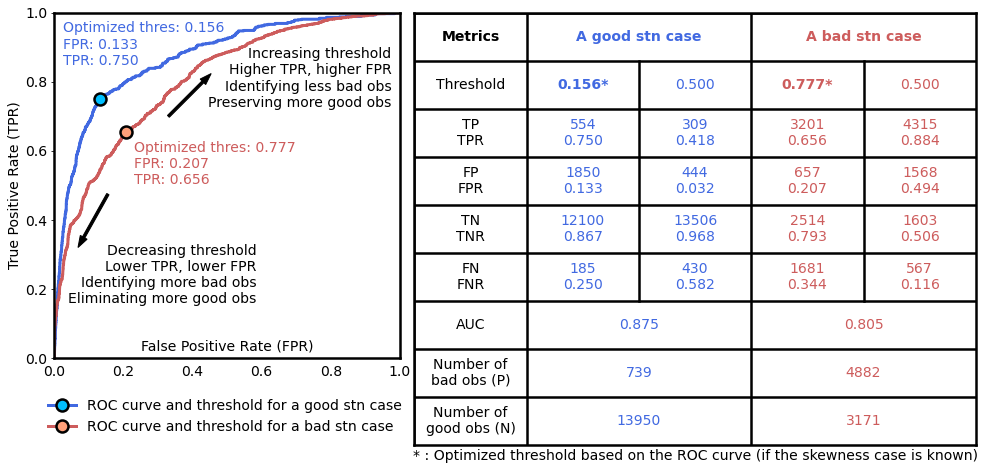

In [339]:
C_good = [gu.xcolor('royal blue'), gu.xcolor('deep sky blue')]
C_bad = [gu.xcolor('indian red'), gu.xcolor('light salmon')]
fig = plt.figure(figsize=(13, 6))

gs = gridspec.GridSpec(2, 2, height_ratios=[0.8, 0.2], width_ratios=[0.4, 0.6])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[:, 1])
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

#ax1.grid(linestyle=':')#; ax.xaxis.grid(False)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
[j.set_linewidth(2.5) for j in ax1.spines.values()]
ax1.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=True, right=False, labelleft=True)
ax1.set_ylabel("True Positive Rate (TPR)", fontsize=14)
ax1.set_xlabel("False Positive Rate (FPR)", labelpad=-40, fontsize=14)

ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])

# ----- ROCs ----- #
ax1.plot(FPR_good, TPR_good, color=C_good[0], lw=3)
ax1.plot(FPR_bad, TPR_bad, color=C_bad[0], lw=3)
ax1.plot(FPR_good[pick_good], TPR_good[pick_good], 'bo', ms=12, mec='k', mfc=C_good[1], mew=2.5)
ax1.plot(FPR_bad[pick_bad], TPR_bad[pick_bad], 'ro', ms=12, mec='k', mfc=C_bad[1], mew=2.5)

words_bad = "Optimized thres: {:.3f}\nFPR: {:.3f}\nTPR: {:.3f}".format(thres_bad[pick_bad], FPR_bad[pick_bad], TPR_bad[pick_bad])
words_good = "Optimized thres: {:.3f}\nFPR: {:.3f}\nTPR: {:.3f}".format(thres_good[pick_good], FPR_good[pick_good], TPR_good[pick_good])
words_up = "Increasing threshold\nHigher TPR, higher FPR\nIdentifying less bad obs\nPreserving more good obs"
words_down = "Decreasing threshold\nLower TPR, lower FPR\nIdentifying more bad obs\nEliminating more good obs"

ax1.text(0.23, 0.63, words_bad, ha='left', va='top', color=C_bad[0], fontsize=14);
ax1.text(0.025, 0.975, words_good, ha='left', va='top', color=C_good[0], fontsize=14);

ax1.text(0.975, 0.9, words_up, ha='right', va='top', fontsize=14);
ax1.text(0.585, 0.15, words_down, ha='right', va='bottom', fontsize=14);

ax1.arrow(0.33, 0.7, 0.1, 0.1, width=0.0075, fc='k', ec='k')
ax1.arrow(0.155, 0.475, -0.07, -0.125, width=0.0075, fc='k', ec='k')

legend_box = []
legend_box.append(mlines.Line2D([], [], marker='o', ms=12, mec='k', mfc=C_good[1], mew=2.5, color=C_good[0], lw=3,
                                label='ROC curve and threshold for a good stn case'))
legend_box.append(mlines.Line2D([], [], marker='o', ms=12, mec='k', mfc=C_bad[1], mew=2.5, color=C_bad[0], lw=3,
                                label='ROC curve and threshold for a bad stn case'))

ax_lg = fig.add_axes([0.0, 0.01, 0.4, 0.125])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)
# ---------------- #
ax2 = gu.ax_decorate_box(ax2)
dy = 1/9
dx = 1/5
locx = [1/10, 3/10, 5/10, 7/10, 9/10]
locm = [1/10, 4/10, 8/10]
locy = 1-0.5*dy

for i in range(9):
    if i == 0:
        font = 'bold'
        ax2.axhline(y=1.0-dy*i, xmin=0, xmax=1, color='k', linewidth=2.5)
        ax2.text(locm[0], locy-dy*i, col1[i], fontsize=14, va='center', ha='center', 
                 fontweight=font, transform=ax2.transAxes)
        ax2.text(locm[1], locy-dy*i, col2[i], fontsize=14, va='center', ha='center', 
                 color=C_good[0], fontweight=font, transform=ax2.transAxes)
        ax2.text(locm[2], locy-dy*i, col4[i], fontsize=14, va='center', ha='center', 
                 color=C_bad[0], fontweight=font, transform=ax2.transAxes)
    elif i<6:
        j = i-1
        font = 'normal'
        if i == 1:
            font_thres = 'bold'
        else:
            font_thres = 'normal'
            
        ax2.axhline(y=1.0-dy*i, xmin=0, xmax=1, color='k', linewidth=2.5)
        ax2.text(locx[0], locy-dy*i, col1[i], fontsize=14, va='center', ha='center', 
                 fontweight=font, transform=ax2.transAxes)
        ax2.text(locx[1], locy-dy*i, col2[i], fontsize=14, va='center', ha='center', 
                 color=C_good[0], fontweight=font_thres, transform=ax2.transAxes)
        ax2.text(locx[2], locy-dy*i, col3[j], fontsize=14, va='center', ha='center', 
                 color=C_good[0], fontweight=font, transform=ax2.transAxes)
        ax2.text(locx[3], locy-dy*i, col4[i], fontsize=14, va='center', ha='center', 
                 color=C_bad[0], fontweight=font_thres, transform=ax2.transAxes)
        ax2.text(locx[4], locy-dy*i, col5[j], fontsize=14, va='center', ha='center', 
                 color=C_bad[0], fontweight=font, transform=ax2.transAxes)
    else:
        font = 'normal'
        ax2.axhline(y=1.0-dy*i, xmin=0, xmax=1, color='k', linewidth=2.5)
        ax2.text(locm[0], locy-dy*i, col1[i], fontsize=14, va='center', ha='center', 
                 fontweight=font, transform=ax2.transAxes)
        ax2.text(locm[1], locy-dy*i, col2[i], fontsize=14, va='center', ha='center', 
                 color=C_good[0], fontweight=font, transform=ax2.transAxes)
        ax2.text(locm[2], locy-dy*i, col4[i], fontsize=14, va='center', ha='center', 
                 color=C_bad[0], fontweight=font, transform=ax2.transAxes)        
    
for i in range(5):
    if i == 2 or i == 4:
        ax2.axvline(x=dx*i, ymin=3*dy, ymax=1-dy, color='k', linewidth=2.5)
    else:
        ax2.axvline(x=dx*i, ymin=0, ymax=1, color='k', linewidth=2.5)

ax_text = fig.add_axes([0.399, -0.035, 0.6, 0.03])
ax_text.set_axis_off()
ax_text.text(0, 0, '* : Optimized threshold based on the ROC curve (if the skewness case is known)', fontsize=14);

fig.savefig(fig_dir+'QC_thresholding.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

# Timeseries

In [37]:
import tensorflow as tf
from tensorflow import keras

In [5]:
hdf_io = h5py.File(INPUT_dir+'HIGH_DBASE_ELR.hdf', 'r')
print(hdf_io.keys())
capa_input = hdf_io['capa_input'][...]
stn_input = hdf_io['stn_input'][...]
hdf_io.close()

<KeysViewHDF5 ['capa_input', 'stn_input', 'test_ind', 'time_info', 'train_ind', 'valid_ind', 'xstn_info']>


In [6]:
INPUT_dir

'/glade/scratch/ksha/DATA/QC_64_64/'

In [39]:
for i in range(5):
    pick = 2*i
    capa_input[..., pick] = qu.crop_stn(capa_input[..., pick], stn_input[:, 1], padx=[1, 1], pady=[1, 1])

In [40]:
save_dir = '/glade/work/ksha/data/Keras/QC_publish/'

In [41]:
model_member = []
for i in range(ens):
    key = freq+'QC_CNN'+str(i)
    print('\t {}'.format(key))
    model_member.append(keras.models.load_model(save_dir+key+'.hdf'))

	 HIGH_QC_CNN0
	 HIGH_QC_CNN1
	 HIGH_QC_CNN2
	 HIGH_QC_CNN3
	 HIGH_QC_CNN4


In [53]:
model_ens = keras.models.load_model(save_dir+'QC_ENS.hdf')
qc_flags = qu.ensemble_predict(model_member, model_ens, capa_input)

Preparing member outputs
Member 0
Member 1
Member 2
Member 3
Member 4
Preparing ensemble outputs


In [54]:
true_flag = np.abs(stn_input[200:400, 0]-stn_input[200:400, 1])>0.5

**stn meta**

In [55]:
n = 45 # ELR
lonp = stn_lon[n]
latp = stn_lat[n]
hdf_io = h5py.File(GRID_INPUT_file, 'r')
xgrid1, ygrid1 = hdf_io['xgrid1'][...], hdf_io['ygrid1'][...] # 38 km
xgrid4, ygrid4 = hdf_io['xgrid4'][...], hdf_io['ygrid4'][...] # 10 km (now 15 km, BCH QC-er uses 15 km)
hdf_io.close()

In [56]:
stnx1, stny1 = du.grid_search(xgrid1, ygrid1, np.array([lonp]), np.array([latp]))
stnx4, stny4 = du.grid_search(xgrid4, ygrid4, np.array([lonp]), np.array([latp]))

In [57]:
lon_grid1 = xgrid1[stnx1[0]-32:stnx1[0]+32, stny1[0]-32:stny1[0]+32]
lat_grid1 = ygrid1[stnx1[0]-32:stnx1[0]+32, stny1[0]-32:stny1[0]+32]

lon_grid4 = xgrid4[stnx4[0]-32:stnx4[0]+32, stny4[0]-32:stny4[0]+32]
lat_grid4 = ygrid4[stnx4[0]-32:stnx4[0]+32, stny4[0]-32:stny4[0]+32]

In [58]:
d = 0.1

BOX1_x = np.vstack([lon_grid1[32-1, 32-1]+d, lon_grid1[32-1, 32+1]-d, lon_grid1[32+1, 32+1]-d, lon_grid1[32+1, 32-1]+d])
BOX1_y = np.vstack([lat_grid1[32-1, 32-1], lat_grid1[32-1, 32+1], lat_grid1[32+1, 32+1], lat_grid1[32+1, 32-1]])

d = 0.025
BOX5_x = np.vstack([lon_grid4[32-1, 32-1]+d, lon_grid4[32-1, 32+1]-d, lon_grid4[32+1, 32+1]-d, lon_grid4[32+1, 32-1]+d])
BOX5_y = np.vstack([lat_grid4[32-1, 32-1], lat_grid4[32-1, 32+1], lat_grid4[32+1, 32+1], lat_grid4[32+1, 32-1]])

In [59]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# BC and Ca-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

shape_dir = fig_dir+'wshed_hires/MajorHydroWatershedsProject.shp'

In [60]:
dx1 = lon_grid1.max()-lonp
dy1 = lat_grid1.max()-latp
dx4 = lon_grid4.max()-lonp
dy4 = lat_grid4.max()-latp

# rate1 = (lat_grid1.max()-lat_grid1.min())/(lon_grid1.max()-lon_grid1.min())
# rate5 = (lat_grid5.max()-lat_grid5.min())/(lon_grid5.max()-lon_grid5.min())
rate = 1.05#rate1/rate5

edge1 = [lonp-dx1, lonp+dx1, latp-dy1, latp+dy1]
edge4 = [lonp-dx4, lonp+dx4, latp-rate*dy4, latp+rate*dy4]

In [61]:
import cmaps
import matplotlib.colors as colors

In [62]:
cmap_pct = plt.cm.gist_ncar_r

C3 = '0.7'
C4 = '0.3'

C1 = '0.7'
C2 = '0.3'

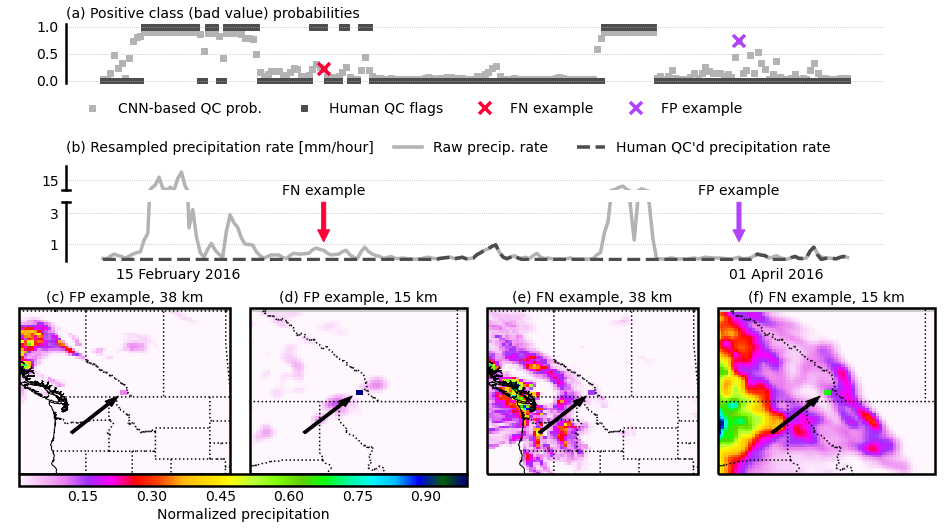

In [63]:
fig = plt.figure(figsize=(13, 6.75))

ax1  = plt.subplot2grid((14, 16), (0, 1), rowspan=2, colspan=14)
ax21 = plt.subplot2grid((14, 16), (4, 1), rowspan=1, colspan=14)
ax22 = plt.subplot2grid((14, 16), (5, 1), rowspan=2, colspan=14)

ax31 = plt.subplot2grid((14, 16), (8, 0) , rowspan=5, colspan=4, projection=ccrs.PlateCarree())
ax32 = plt.subplot2grid((14, 16), (8, 4) , rowspan=5, colspan=4, projection=ccrs.PlateCarree())
ax33 = plt.subplot2grid((14, 16), (8, 8) , rowspan=5, colspan=4, projection=ccrs.PlateCarree())
ax34 = plt.subplot2grid((14, 16), (8, 12) , rowspan=5, colspan=4, projection=ccrs.PlateCarree())

ax_gap1 = plt.subplot2grid((14, 3), (3, 0), rowspan=1, colspan=8)
ax_gap2 = plt.subplot2grid((14, 3), (7, 0), rowspan=1, colspan=8)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.5, wspace=0)

fake_x = np.arange(200)
AX = [ax1, ax21, ax22]
for ax in AX:
    gu.ax_decorate(ax, True, True)
    #ax.yaxis.grid(False)
ax1.tick_params(labelbottom=False)
ax1.set_yticks([0, 0.5, 1.0])

handle_line = []
handle_star = []
handle_line += ax1.plot(fake_x, qc_flags[200:400], 'rs', lw=3.5, color=C1, label='CNN-based QC prob.', zorder=1)
handle_line += ax1.plot(fake_x, true_flag, 'rs', lw=3.5, color=C2, label='Human QC flags', zorder=1)

#inds = [135, 125, 170, 59]
inds = [170, 59]
C = [cmap_pct(36), cmap_pct(64)] #gu.xcolor('royal blue'), gu.xcolor('dark sea green'),
star_labels = ['FP example', 'FN example']
map_labels = ['FP example, 38 km', 'FP example, 15 km',
              'FN example, 38 km', 'FN example, 15 km']
for i, ind in enumerate(inds):
    handle_star += ax1.plot(fake_x[ind], qc_flags[200+ind], 'rx', ms=12, mec=C[i], mfc=C[i], 
                            mew=3.5, label=star_labels[i], zorder=3)

ax21.tick_params(labelbottom=False)
ax21.set_yticks([15]); ax22.set_yticks([1, 3])
ax21.plot(fake_x, stn_input[200:400, 1], lw=3.5, color=C3)
handle_line += ax22.plot(fake_x, stn_input[200:400, 1], lw=3.5, color=C3, label='Raw precip. rate')
handle_line += ax22.plot(fake_x, stn_input[200:400, 0], lw=3.5, color=C4, 
                         linestyle='--', label="Human QC'd precipitation rate")


for i, ind in enumerate(inds):
    ax.annotate(star_labels[i],
                xy=(fake_x[ind], 1), xycoords='data',
                xytext=(fake_x[ind], 4), textcoords='data',
                arrowprops=dict(facecolor=C[i], edgecolor=C[i], shrink=0.05),
                ha='center', va='bottom', fontsize=14)

ax21.set_ylim([5, 30])  # outliers only
ax22.set_ylim([-0.1, 3.75])  # most of the data
ax22.set_xticks([20, 180])
ax22.set_xticklabels(['15 February 2016', '01 April 2016'])
#
d = 0.005
ax21.plot((-d, d), (d, d), color='k', lw=2.5, clip_on=False, transform=ax21.transAxes)
ax22.plot((-d, d), (1+d, 1+d), color='k', lw=2.5, clip_on=False, transform=ax22.transAxes)
#
inds[-1] += 1
AX3 = [ax31, ax33]
AX4 = [ax32, ax34]
arrow_flag = [True, True, True, True]
#
for i, ax in enumerate(AX3):
    ax.set_extent(edge1, ccrs.Geodetic())
    capa_plot = np.copy(capa_input[200+inds[i], ..., 0])
    ax.pcolormesh(lon_grid1, lat_grid1, capa_plot, vmin=0.01, vmax=0.99, cmap=cmap_pct)
    if arrow_flag[i]:
        ax.arrow(0.25, 0.25, 0.175, 0.175, width=0.015, fc='k', ec='k', transform=ax.transAxes)

for i, ax in enumerate(AX4):
    ax.set_extent(edge4, ccrs.Geodetic())
    capa_plot = np.copy(capa_input[200+inds[i], ..., -2])
    CS = ax.pcolormesh(lon_grid4, lat_grid4, capa_plot, vmin=0.01, vmax=0.99, cmap=cmap_pct)

    ax.arrow(0.25, 0.25, 0.175, 0.175, width=0.015, fc='k', ec='k', transform=ax.transAxes)

for ax in AX3+AX4:
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.8')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=2)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle=':', linewidth=1.5, zorder=2)
    ax.outline_patch.set_linewidth(2.5)

ax1.set_title('(a) Positive class (bad value) probabilities', x=0, ha='left', fontsize=14)

handle_temp = handle_line[:2] + [handle_star[1]] + [handle_star[0]]
ax_lg = fig.add_axes([1/16, 0.815, 0.85, 0.05])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=handle_temp, prop={'size':14}, ncol=4, loc=2, fancybox=False);
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1)

ax_lg = fig.add_axes([0.4, 0.735, 0.525, 0.05])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=handle_line[2:], prop={'size':14}, ncol=2, loc=2, fancybox=False);
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1)

ax_base = fig.add_axes([0.0125, 0, 0.479, 0.075]) # 0.52, 0.2535, 0.4615, 0.07
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='35%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Normalized precipitation', fontsize=14)
tick_locator = ticker.MaxNLocator(nbins=7)
CBar.locator = tick_locator
CBar.update_ticks()
CBar.outline.set_linewidth(2.5)

ax_gap1.set_axis_off()
ax_gap1.text(1/16, 0, '(b) Resampled precipitation rate [mm/hour]', 
                  va='bottom', ha='left', fontsize=14, transform=ax_gap1.transAxes)
ax_gap2.set_axis_off()
letters = ['(c) ', '(d) ', '(e) ', '(f) ']
locx = np.arange(1/8, 1, 1/4)
for i in range(4):
    ax_gap2.text(locx[i], -0.35, letters[i]+map_labels[i], va='bottom', ha='center', 
                 fontsize=14, transform=ax_gap2.transAxes)

# fig.savefig(fig_dir+'QC_examples.png', dpi=250, orientation='portrait', 
#            papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

In [98]:
# fig = plt.figure(figsize=(13, 9.2))

# ax1  = plt.subplot2grid((18, 4), (0, 0), rowspan=3, colspan=4)
# ax21 = plt.subplot2grid((18, 4), (4, 0), rowspan=1, colspan=4)
# ax22 = plt.subplot2grid((18, 4), (5, 0), rowspan=2, colspan=4)

# ax31 = plt.subplot2grid((18, 4), (8, 0) , rowspan=5, colspan=1, projection=ccrs.PlateCarree())
# ax32 = plt.subplot2grid((18, 4), (8, 1) , rowspan=5, colspan=1, projection=ccrs.PlateCarree())
# ax33 = plt.subplot2grid((18, 4), (8, 2) , rowspan=5, colspan=1, projection=ccrs.PlateCarree())
# ax34 = plt.subplot2grid((18, 4), (8, 3) , rowspan=5, colspan=1, projection=ccrs.PlateCarree())
# #ax41 = plt.subplot2grid((18, 4), (13, 0), rowspan=5, colspan=1, projection=ccrs.PlateCarree())
# #ax42 = plt.subplot2grid((18, 4), (13, 1), rowspan=5, colspan=1, projection=ccrs.PlateCarree())
# ax43 = plt.subplot2grid((18, 4), (13, 2), rowspan=5, colspan=1, projection=ccrs.PlateCarree())
# ax44 = plt.subplot2grid((18, 4), (13, 3), rowspan=5, colspan=1, projection=ccrs.PlateCarree())

# ax_gap1 = plt.subplot2grid((18, 4), (3, 0), rowspan=1, colspan=4)
# ax_gap2 = plt.subplot2grid((18, 4), (7, 0), rowspan=1, colspan=4)

# plt.subplots_adjust(0, 0, 1, 1, hspace=0.5, wspace=0)

# fake_x = np.arange(200)
# AX = [ax1, ax21, ax22]
# for ax in AX:
#     gu.ax_decorate(ax, True, True)
#     #ax.yaxis.grid(False)
# ax1.tick_params(labelbottom=False)
# ax1.set_yticks([0, 0.5, 1.0])

# handle_line = []
# handle_star = []
# handle_line += ax1.plot(fake_x, qc_flags[200:400], lw=3.5, color=C1, label='CNN-based QC prob.')
# handle_line += ax1.plot(fake_x, true_flag, lw=3.5, color=C2, linestyle='--', label='Human QC prob.')

# inds = [135, 125, 170, 59]
# C = [gu.xcolor('royal blue'), gu.xcolor('dark sea green'), gu.xcolor('indian red'), gu.xcolor('gold')]
# star_labels = ['Correctly classif. bad obs', 'Correctly classif. good obs', 
#                'Miss classif. good obs', 'Miss classif. bad obs']
# for i, ind in enumerate(inds):
#     handle_star += ax1.plot(fake_x[ind], qc_flags[200+ind], 'r*', ms=20, mec='k', mfc=C[i], mew=1.5, label=star_labels[i])

# ax21.tick_params(labelbottom=False)
# ax21.set_yticks([15]); ax22.set_yticks([1, 3])
# ax21.plot(fake_x, stn_input[200:400, 1], lw=3.5, color=C3)
# handle_line += ax22.plot(fake_x, stn_input[200:400, 1], lw=3.5, color=C3, label='Raw precip. rate')
# handle_line += ax22.plot(fake_x, stn_input[200:400, 0], lw=3.5, color=C4, 
#                          linestyle='--', label="Human QC'd precip. rate")
# ax21.set_ylim([5, 30])  # outliers only
# ax22.set_ylim([-0.1, 3.75])  # most of the data
# ax22.set_xticks([20, 180])
# ax22.set_xticklabels(['Feb-15-2016', 'Apr-01-2016'])
# #
# d = 0.005
# ax21.plot((-d, d), (d, d), color='k', lw=2.5, clip_on=False, transform=ax21.transAxes)
# ax22.plot((-d, d), (1+d, 1+d), color='k', lw=2.5, clip_on=False, transform=ax22.transAxes)
# #
# inds[-1] += 1
# AX3 = [ax31, ax32, ax33, ax34]
# AX4 = [ax43, ax44]
# arrow_flag = [True, False, True, True]
# #
# for i, ax in enumerate(AX3):
#     ax.set_extent(edge1, ccrs.Geodetic())
#     capa_plot = np.copy(capa_input[200+inds[i], ..., 0])
#     #capa_plot[31:33, 32] = 0.1*capa_plot[31:33, 32]
#     #capa_plot[32, 31] = 0.1*capa_plot[32, 31]
#     ax.pcolormesh(lon_grid1, lat_grid1, capa_plot, vmin=0.01, vmax=0.99, cmap=plt.cm.gist_ncar_r)
#     handle = ax.text(0.0175, 0.9125, '38 km grid spacing', fontsize=14, transform=ax.transAxes)
#     handle.set_bbox(dict(facecolor='w', alpha=1, edgecolor='k', linewidth=2.5))
#     if arrow_flag[i]:
#         ax.arrow(0.25, 0.25, 0.175, 0.175, width=0.015, fc='k', ec='k', transform=ax.transAxes)
# #         points = np.array([[BOX1_x[0, 0], BOX1_y[0, 0]],
# #                            [BOX1_x[1, 0], BOX1_y[1, 0]],
# #                            [BOX1_x[2, 0], BOX1_y[2, 0]],
# #                            [BOX1_x[3, 0], BOX1_y[3, 0]]])
# #         boxes = PatchCollection([mpatches.Polygon(points)], facecolor='none', edgecolor='k', linewidth=1.0)
# #        ax.add_collection(boxes)

# for i, ax in enumerate(AX4):
#     ax.set_extent(edge5, ccrs.Geodetic())
#     capa_plot = np.copy(capa_input[200+inds[2+i], ..., -2])
#     CS = ax.pcolormesh(lon_grid5, lat_grid5, capa_plot, vmin=0.01, vmax=0.99, cmap=plt.cm.gist_ncar_r)
#     handle = ax.text(0.0175, 0.9135, '10 km grid spacing', fontsize=14, transform=ax.transAxes)
#     handle.set_bbox(dict(facecolor='w', alpha=1, edgecolor='k', linewidth=2.5))
#     ax.arrow(0.25, 0.25, 0.175, 0.175, width=0.015, fc='k', ec='k', transform=ax.transAxes)

# for ax in AX3+AX4:
#     ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.85')
#     ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=2)
#     ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=2)
#     ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle=':', linewidth=1.5, zorder=2)
#     ax.outline_patch.set_linewidth(2.5)
    
# ax1.set_title('(a) Bad value probabilities', x=0, ha='left', fontsize=14)

# ax_lg = fig.add_axes([0.525, 0.8375, 0.01, 0.01])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=handle_line, prop={'size':14}, ncol=2, loc=2, fancybox=False);
# LG.get_frame().set_facecolor('white')
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(0)
# LG.get_frame().set_alpha(1)

# ax_lg = fig.add_axes([0, 0.225, 0.01, 0.01])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=handle_star, prop={'size':14}, ncol=2, loc=2, fancybox=False);
# LG.get_frame().set_facecolor('white')
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(2.5)
# LG.get_frame().set_alpha(1)

# ax_base = fig.add_axes([0.0075, 0.03, 0.486, 0.075]) # 0.52, 0.2535, 0.4615, 0.07
# [j.set_linewidth(0) for j in ax_base.spines.values()]
# ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
#                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
# cax = inset_axes(ax_base, width='100%', height='35%', borderpad=0, loc=9)
# CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
# CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
# CBar.set_label('Normalized CaPA feature map', fontsize=14)
# #CBar.ax.xaxis.set_ticks_position('top')
# #CBar.ax.xaxis.set_label_position('top')
# tick_locator = ticker.MaxNLocator(nbins=7)
# CBar.locator = tick_locator
# CBar.update_ticks()
# CBar.outline.set_linewidth(2.5)

# ax_gap1.set_axis_off()
# ax_gap1.text(0, 0, '(b) Resampled non-zero precipitation rate [mm/hour]', 
#                   va='bottom', ha='left', fontsize=14, transform=ax_gap1.transAxes)
# ax_gap2.set_axis_off()
# letters = ['(c) ', '(d) ', '(e) ', '(f) ']
# locx = np.arange(1/8, 1, 1/4)
# for i in range(4):
#     ax_gap2.text(locx[i], -0.45, letters[i]+star_labels[i], va='bottom', ha='center', 
#                  fontsize=14, transform=ax_gap2.transAxes)

# fig.savefig(fig_dir+'QC_examples.png', dpi=250, orientation='portrait', 
#            papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

Text(0.5,1,'True Negative (38 km)')

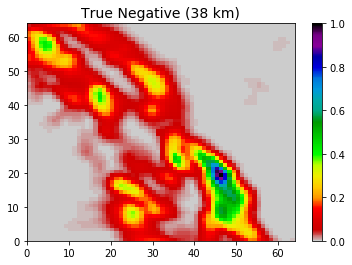

In [101]:
plt.pcolormesh(capa_input[325, ..., -2], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()
plt.title('True Negative (38 km)', fontsize=14)

Text(0.5,1,'False Positive (38 km)')

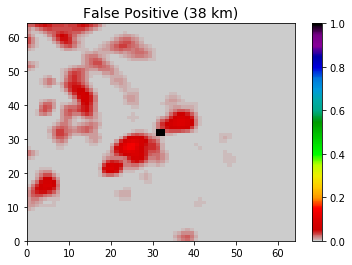

In [242]:
plt.pcolormesh(capa_input[370, ..., -2], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()
plt.title('False Positive (38 km)', fontsize=14)

Text(0.5,1,'False Negative (38 km)')

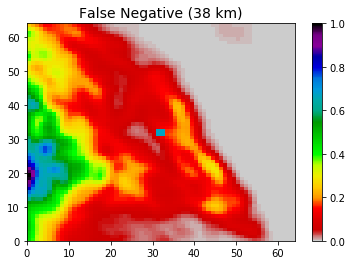

In [243]:
plt.pcolormesh(capa_input[260, ..., -2], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()
plt.title('False Negative (38 km)', fontsize=14)

Text(0.5,1,'False Negative (10 km)')

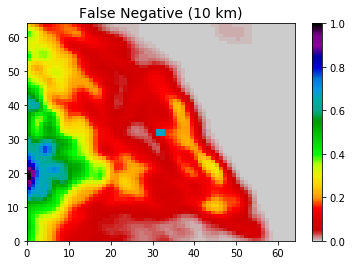

In [218]:
plt.pcolormesh(capa_input[260, ..., -2], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()
plt.title('False Negative (10 km)', fontsize=14)

In [91]:
np.array([13.6, 28.6, 245])*7

array([  95.2,  200.2, 1715. ])

**Testing code**

In [29]:
# labels = ['10 km', '15 km', '22 km', '30 km', '38 km']

# fig = plt.figure(figsize=(13, 6.5))

# ax1 = plt.subplot2grid((4, 2), (0, 0))
# ax2 = plt.subplot2grid((4, 2), (1, 0))
# ax3 = plt.subplot2grid((4, 2), (2, 0))
# ax4 = plt.subplot2grid((4, 2), (3, 0))

# ax5 = plt.subplot2grid((4, 2), (0, 1))
# ax6 = plt.subplot2grid((4, 2), (1, 1))
# ax7 = plt.subplot2grid((4, 2), (2, 1))
# ax8 = plt.subplot2grid((4, 2), (3, 1))

# AX1 = [ax1, ax2, ax3, ax4]
# AX2 = [ax5, ax6, ax7, ax8]
# AX = AX1+AX2
# X_left = np.array(['Good Negative Rate', 'Hit Rate'])
# edge_loc = 0.7
# text_gap1 = 0.03
# text_gap2 = 0.08
# bar_gap = 0.105
# for i, ax in enumerate(AX1):
#     ax = gu.ax_decorate(ax, True, False)
#     ax.set_ylim([0.6, 1])
#     ax.set_yticks([0.7, 0.8, 0.9])
#     ax.grid(False)
#     ax.spines["bottom"].set_visible(True)
#     for j in range(6):
#         ax.bar(np.array([0+bar_gap*j, edge_loc+bar_gap*j]), M[0, :, j, i], width=0.075, linewidth=2.0, edgecolor='k', facecolor=JET[j])
#         ax.text(np.array([0+bar_gap*j]), M[0, 0, j, i]+text_gap, str(np.round(M[0, 0, j, i], 2)), va='center', ha='center', fontsize=10)
#         ax.text(np.array([edge_loc+bar_gap*j]), M[0, 1, j, i]+text_gap1, str(np.round(M[0, 1, j, i], 2)), va='center', ha='center', fontsize=10)
        
# for i, ax in enumerate(AX2):
#     ax = gu.ax_decorate(ax, True, False)
#     ax.set_ylim([0, 1])
#     ax.set_yticks([0.1, 0.3, 0.5])
    
    
#     ax.grid(False)
#     ax.spines["left"].set_visible(False)
#     ax.spines["right"].set_visible(True)
#     ax.spines["bottom"].set_visible(True)
#     ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=False, left=False, labelleft=False, right=False, labelright=True)
#     for j in range(6):
#         ax.bar(np.array([0+bar_gap*j, edge_loc+bar_gap*j]), 1-M[1, :, j, i], width=0.075, linewidth=2.0, edgecolor='k', facecolor=JET[j])
#         ax.text(np.array([0+bar_gap*j]), 1-M[1, 0, j, i]+text_gap, str(np.round(1-M[1, 0, j, i], 2)), va='center', ha='center', fontsize=10)
#         ax.text(np.array([edge_loc+bar_gap*j]), 1-M[1, 1, j, i]+text_gap2, str(np.round(1-M[1, 1, j, i], 2)), va='center', ha='center', fontsize=10)

# ax5.text(0.975, 0.805, 'Support: {}\nBest member: 15 km, AUC: {}\nClassifier ensemble AUC: {}'.format(int(M[-1, 0, 0, 0]), np.round(AUC[0, 3], 3), np.round(AUC[0, -1], 3)), ha='right', va='center', fontsize=10, transform=ax5.transAxes)
# ax6.text(0.975, 0.805, 'Support: {}\nBest member: 22 km, AUC: {}\nClassifier ensemble AUC: {}'.format(int(M[-1, 0, 0, 1]), np.round(AUC[1, 2], 3), np.round(AUC[1, -1], 3)), ha='right', va='center', fontsize=10, transform=ax6.transAxes)
# ax7.text(0.975, 0.805, 'Support: {}\nBest member: 30 km, AUC: {}\nClassifier ensemble AUC: {}'.format(int(M[-1, 0, 0, 2]), np.round(AUC[2, 1], 3), np.round(AUC[2, -1], 3)), ha='right', va='center', fontsize=10, transform=ax7.transAxes)
# ax8.text(0.975, 0.805, 'Support: {}\nBest member: 30 km, AUC: {}\nClassifier ensemble AUC: {}'.format(int(M[-1, 0, 0, 3]), np.round(AUC[3, 1], 3), np.round(AUC[3, -1], 3)), ha='right', va='center', fontsize=10, transform=ax8.transAxes)

# ax4.tick_params(labelbottom=True)
# ax4.spines["bottom"].set_visible(True)
# ax4.set_xticks([3*bar_gap-0.05, edge_loc+3*bar_gap-0.05])
# ax4.set_xticklabels(['Good Negative Rate', 'Hit Rate'])

# ax8.tick_params(labelbottom=True)
# ax8.spines["bottom"].set_visible(True)
# ax8.set_xticks([3*bar_gap-0.05, edge_loc+3*bar_gap-0.05])
# ax8.set_xticklabels(['False Alarm Rate', 'False Negative Rate'])

# legend_box = []
# for i in range(5):
#     legend_box.append(mpatches.Patch(facecolor=JET[i], edgecolor='k', linewidth=2.0, label='Classifier with {} gridspacing input'.format(labels[::-1][i])))
# legend_box.append(mpatches.Patch(facecolor=JET[5], edgecolor='k', linewidth=2.0, label='Classifier ensemble'))

# ax1.text(1, 1.075, '(a) Vancouver Island stations', ha='center', va='center', fontsize=14, transform=ax1.transAxes, zorder=5)
# ax2.text(1, 1.075, '(b) Southwestern Coast stations', ha='center', va='center', fontsize=14, transform=ax2.transAxes, zorder=5)
# ax3.text(1, 1.075, '(c) Rocky Mountain stations', ha='center', va='center', fontsize=14, transform=ax3.transAxes, zorder=5)
# ax4.text(1, 1.075, '(d) Northern stations', ha='center', va='center', fontsize=14, transform=ax4.transAxes, zorder=5)

# ax_lg = fig.add_axes([0.26, -0.075, 0.5, 0.1])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=2, prop={'size':14});
# LG.get_frame().set_facecolor('white')
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(0)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.375)

# # fig.savefig(fig_dir+'region_bars.png', dpi=250, orientation='portrait', \
# #            papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

In [62]:
len(train_files)

2082